In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.layers import *
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8239468500452272024
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14614343288525723623
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7720588771427696772
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3616354028659754024
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/new/TanKianLong_1181300023/dataset/D3.csv')

In [ ]:
data_train.head()

,text,type
0,"They stood in line at Trump Tower, sometimes u...",0
1,Donald J. Trump <U+2019>s foundation informed ...,0
2,President-elect Donald J. Trump won the White ...,0
3,An investment pitch for a new Texas hotel is t...,0
4,President-elect Donald J. Trump <U+2019>s wife...,0


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015 entries, 0 to 20014
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20015 non-null  object
 1   type    20015 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.9+ KB


In [ ]:
# Convert to lowercase

data_train['text'] = data_train['text'].apply(lambda x: x.lower())
data_train.head()

,text,type
0,"they stood in line at trump tower, sometimes u...",0
1,donald j. trump <u+2019>s foundation informed ...,0
2,president-elect donald j. trump won the white ...,0
3,an investment pitch for a new texas hotel is t...,0
4,president-elect donald j. trump <u+2019>s wife...,0


In [ ]:
# Check
data_train.head()

,text,type
0,"they stood in line at trump tower, sometimes u...",0
1,donald j. trump <u+2019>s foundation informed ...,0
2,president-elect donald j. trump won the white ...,0
3,an investment pitch for a new texas hotel is t...,0
4,president-elect donald j. trump <u+2019>s wife...,0


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data_train['text'] = data_train['text'].apply(punctuation_removal)

In [ ]:
# Check
data_train.head()

,text,type
0,they stood in line at trump tower sometimes up...,0
1,donald j trump u2019s foundation informed atto...,0
2,presidentelect donald j trump won the white ho...,0
3,an investment pitch for a new texas hotel is t...,0
4,presidentelect donald j trump u2019s wife mela...,0


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english','arabic')
stop.extend(["said", "reuters", "CNN", "would", "image", "via"])

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_train.head()

,text,type
0,stood line trump tower sometimes half hour han...,0
1,donald j trump u2019s foundation informed atto...,0
2,presidentelect donald j trump white house outs...,0
3,investment pitch new texas hotel trying lure w...,0
4,presidentelect donald j trump u2019s wife mela...,0


In [ ]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
#print('What the raw input data looks like:')
#print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text2 = data_train.text[i]
    text =  str(text2)
    texts.append(text)
    labels.append(data_train.type[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 280826 unique tokens.


In [ ]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20015, 1000)
Shape of label tensor: (20015, 2)


In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 16012 2002 2001
real & fake news in train,valt,test:
[6472. 9540.]
[ 808. 1194.]
[ 794. 1207.]


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [ ]:
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, '/content/gdrive/My Drive/FYP/report/ALL/LSTM/glove.6B.100d.txt'), encoding="utf8") #The file that you had downloaded and moved from local session to drive.

In [ ]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

Clstm

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False,))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, padding='same',activation='relu')),
model.add(MaxPooling1D(pool_size=2)),


model.add(LSTM(100,  return_sequences=True)),
model.add(GlobalMaxPooling1D()),

model.add(Dense(2, activation='sigmoid')),

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         28082700  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 128)         38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 500, 100)          91600     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Epoch 1/10
126/126 [==============================] - 8s 64ms/step - loss: 0.4641 - accuracy: 0.7749 - val_loss: 0.3522 - val_accuracy: 0.8531
Epoch 2/10
126/126 [==============================] - 8s 61ms/step - loss: 0.3100 - accuracy: 0.8655 - val_loss: 0.2374 - val_accuracy: 0.9021
Epoch 3/10
126/126 [==============================] - 8s 61ms/step - loss: 0.2432 - accuracy: 0.9003 - val_loss: 0.1961 - val_accuracy: 0.9181
Epoch 4/10
126/126 [==============================] - 8s 61ms/step - loss: 0.1984 - accuracy: 0.9199 - val_loss: 0.1692 - val_accuracy: 0.9341
Epoch 5/10
126/126 [==============================] - 8s 62ms/step - loss: 0.1753 - accuracy: 0.9310 - val_loss: 0.1718 - val_accuracy: 0.9316
Epoch 6/10
126/126 [==============================] - 8s 63ms/step - loss: 0.1526 - accuracy: 0.9412 - val_loss: 0.1731 - val_accuracy: 0.9291
Epoch 7/10
126/126 [==============================] - 8s 63ms/step - loss: 0.1457 - accuracy: 0.9435 - val_loss: 0.1516 - val_accuracy: 0.9391

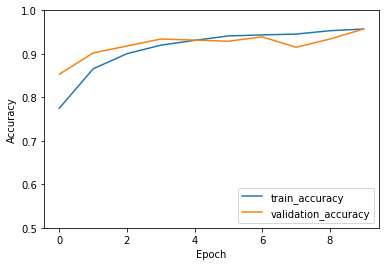

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

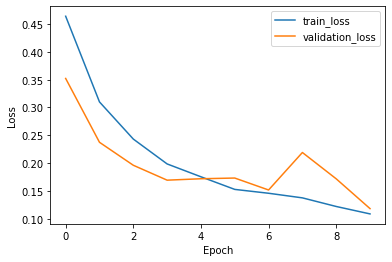

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred = model.predict_classes(x_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

Correct predictions: 1900.0
Total number of test examples: 2001
Accuracy of model1:  0.9495252373813093


In [ ]:
y_test[1]

array([0., 1.], dtype=float32)

In [ ]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
rounded_labels

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)

In [ ]:
print(classification_report(rounded_labels, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.95      0.92      0.94       794
    positive       0.95      0.97      0.96      1207

    accuracy                           0.95      2001
   macro avg       0.95      0.95      0.95      2001
weighted avg       0.95      0.95      0.95      2001

